In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [ ]:
# Load landmark CSV
df = pd.read_csv("/content/drive/MyDrive/Laskar Ai/Capstone/hands.csv", header=None)

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
0,0,0.394281,0.677875,0.505597,0.566018,0.562796,0.471405,0.618305,0.404967,0.648401,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,0.390395,0.639539,0.500793,0.535080,0.563285,0.437713,0.618047,0.371743,0.644000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0,0.435240,0.731819,0.531805,0.608225,0.570717,0.502483,0.619351,0.431132,0.651854,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0,0.428600,0.792728,0.552786,0.662252,0.605064,0.577458,0.653289,0.514694,0.674149,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0,0.470766,0.682559,0.534296,0.631375,0.561131,0.571359,0.589141,0.526871,0.602986,...,0.566829,0.476912,0.437544,0.573359,0.445191,0.492533,0.495873,0.471767,0.542006,0.475955


In [ ]:
# Pisahkan fitur & label
y = df.iloc[:, 0].values      # Kolom pertama sebagai label
X = df.iloc[:, 1:].values     # Sisanya (dari kolom ke-2 sampai akhir) sebagai fitur

In [ ]:
X.shape

(444, 84)

In [ ]:
# # Normalisasi data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

In [ ]:
y_categorical = to_categorical(y)

In [ ]:
# Split dengan data yang sudah diskalakan
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [ ]:
NUM_CLASSES = len(np.unique(y))

print("Jumlah kelas:", len(np.unique(y)))
print("Label yang dikenali:", np.unique(y))


Jumlah kelas: 36
Label yang dikenali: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]


In [ ]:


model = Sequential()
model.add(tf.keras.Input(shape=(X.shape[1],)))  # 84 fitur sesuai data kamu
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(NUM_CLASSES, activation='softmax'))


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
class EarlyStoppingAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, accuracy=0.90):
        super(EarlyStoppingAtAccuracy, self).__init__()
        self.accuracy = accuracy

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if train_acc is not None and train_acc >= self.accuracy:
            print(f"\nTraining accuracy reached {train_acc:.4f}, stopping training!")
            self.model.stop_training = True
        elif val_acc is not None and val_acc >= self.accuracy:
            print(f"\nValidation accuracy reached {val_acc:.4f}, stopping training!")
            self.model.stop_training = True


In [ ]:
# early_stop = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=30,
#     restore_best_weights=True
# )


# history = model.fit(
#     X_train, y_train,
#     epochs=1000,
#     batch_size=16,
#     validation_data=(X_test, y_test),
#     callbacks=[early_stop]
# )

# final_train_acc = history.history['accuracy'][-1]
# final_val_acc = history.history['val_accuracy'][-1]
# print(f'Final training accuracy: {final_train_acc:.4f}')
# print(f'Final validation accuracy: {final_val_acc:.4f}')


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0431 - loss: 4.0365 - val_accuracy: 0.0674 - val_loss: 3.5414 - learning_rate: 5.0000e-04
Epoch 2/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2719 - loss: 2.7731 - val_accuracy: 0.0112 - val_loss: 3.5098 - learning_rate: 5.0000e-04
Epoch 3/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3302 - loss: 2.4436 - val_accuracy: 0.0562 - val_loss: 3.4786 - learning_rate: 5.0000e-04
Epoch 4/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4304 - loss: 2.0681 - val_accuracy: 0.1124 - val_loss: 3.4155 - learning_rate: 5.0000e-04
Epoch 5/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4349 - loss: 2.0492 - val_accuracy: 0.1236 - val_loss: 3.3601 - learning_rate: 5.0000e-04
Epoch 6/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5056 - loss: 1.8392 - val_accuracy: 0.1798 - val_loss: 3.2815 - learning_rate: 5.0000e-04
Epoch 7/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc

In [ ]:
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=16)
print(f'Validation loss: {val_loss:.4f}')
print(f'Validation accuracy: {val_acc:.4f}')


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8262 - loss: 0.6117
Validation loss: 0.5725
Validation accuracy: 0.8427


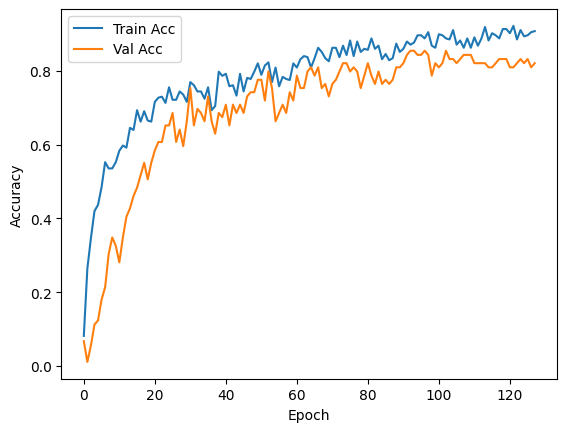

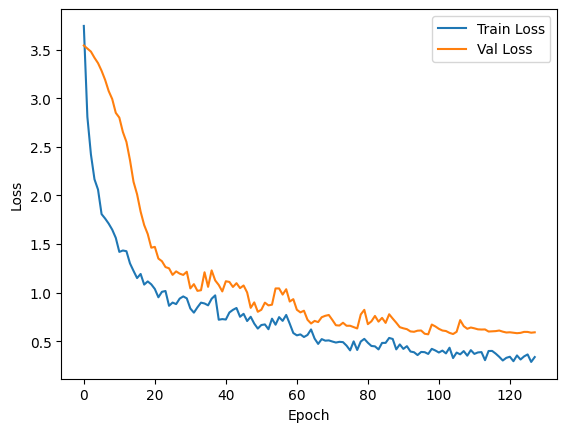

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Simpan model
model.save("gesture_model.h5")